Reference: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/    
https://stackabuse.com/python-for-nlp-working-with-the-gensim-library-part-2/

In [1]:
import pandas as pd
import numpy as np
import re
import os
from os import path

# Gensim Package
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy for lemmatization
import spacy

# Plotting package
import matplotlib.pyplot as plt

#logging
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(mmessage)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import nltk
from nltk.stem import WordNetLemmatizer
en_stop = set(nltk.corpus.stopwords.words('english'))

In [2]:
# Load files from directory
root_folder = "topicmodel_speeches"
files = os.listdir(root_folder)

## Read the speeches from the text file and load into a list

In [3]:
#load speeches into a list
speeches = [] 
file_names = []
for file in files:
    with open(path.join(root_folder, file), 'r') as file_desc:
       text = file_desc.read()
       speeches.append(text)
       file_names.append(file)


## Extract President Name and Date of Speech by parsing the file name
example :  file name: "1789-10-03 George Washington.txt" - first part of file name is date of speech and second part is name of president

In [4]:
def extract_metaData(file_names):
    date_of_speech =[]
    president_names = []
    
    for file in file_names:
        data = file.replace('.txt','')
        data = data.split(' ',1)
        
        date_of_speech.append(data[0])
        president_names.append(data[1])

    return date_of_speech, president_names
    
# call the extract_metaData function to parse the file name and extract date of speech and name of president    
date_of_speech, president_names = extract_metaData(file_names)    

In [5]:
print("\n",date_of_speech[1],president_names[1],"\n",speeches[1][0:100])
print("\n",date_of_speech[80],president_names[80],"\n",speeches[80][0:100])
print("\n",date_of_speech[190],president_names[190],"\n",speeches[190][0:100])


 1789-10-03 George Washington 
 Whereas it is the duty of all Nations to acknowledge the providence of Almighty God to obey his will

 1820-11-14 James Monroe 
 Fellow Citizens of the Senate and of the House of Representatives: In communicating to you a just vi

 1903-12-07 Theodore Roosevelt 
 To the Senate and House of Representatives: The country is to be congratulated on the amount of subs


## Perform pre-processing of speech data:
1. Clean   
\w (word character) matches any single letter, number or underscore    
\s+       One or more spaces
2. Tokenize    
3. Lemmatize  

In [6]:
stemmer = WordNetLemmatizer()

def preprocess_speech(speech):
        # Remove all the special characters
        speech = re.sub(r'\W', ' ', str(speech))

        # remove all single characters
        speech = re.sub(r'\s+[a-zA-Z]\s+', ' ', speech)

        # Remove single characters from the start
        speech = re.sub(r'\^[a-zA-Z]\s+', ' ', speech)

        # Substituting multiple spaces with single space
        speech = re.sub(r'\s+', ' ', speech, flags=re.I)

        # Converting to Lowercase
        speech = speech.lower()

        # Lemmatization
        tokens = speech.split()
        tokens = [stemmer.lemmatize(word) for word in tokens]
        tokens = [word for word in tokens if word not in en_stop]
        tokens = [word for word in tokens if len(word)  > 5]

        return tokens

In [7]:
processed_speeches = []
for speech in speeches:
    tokens = preprocess_speech(speech)
    processed_speeches.append(tokens)


In [8]:
print("\n",date_of_speech[0],president_names[0],"\n",processed_speeches[0][0:100])
print("\n",date_of_speech[80],president_names[80],"\n",processed_speeches[80][0:100])
print("\n",date_of_speech[190],president_names[190],"\n",processed_speeches[190][0:100])


 1789-04-30 George Washington 
 ['fellow', 'citizen', 'senate', 'representative', 'vicissitude', 'incident', 'filled', 'greater', 'anxiety', 'notification', 'transmitted', 'received', 'fourteenth', 'present', 'summoned', 'country', 'veneration', 'retreat', 'chosen', 'fondest', 'predilection', 'flattering', 'immutable', 'decision', 'asylum', 'declining', 'retreat', 'rendered', 'necessary', 'addition', 'inclination', 'frequent', 'interruption', 'health', 'gradual', 'committed', 'magnitude', 'difficulty', 'country', 'called', 'sufficient', 'awaken', 'wisest', 'experienced', 'citizen', 'distrustful', 'scrutiny', 'qualification', 'overwhelm', 'dispondence', 'inheriting', 'inferior', 'endowment', 'nature', 'unpractised', 'administration', 'peculiarly', 'conscious', 'deficencies', 'conflict', 'emotion', 'faithful', 'collect', 'appreciation', 'circumstance', 'affected', 'executing', 'swayed', 'grateful', 'remembrance', 'former', 'instance', 'affectionate', 'sensibility', 'transcendent', 'conf

<!-- ## Tokenize the words and removing the punctuations and unnecassary characters  -->
<!-- We will use Gensim's simple_preprocess() function for this task -->

# Topic modelling
###  LDA   
Term Document Freq: (word_id, word_frequency)

In [9]:
# Create Dictionary
id2word = corpora.Dictionary(processed_speeches)
# id2word.compactify()

# Create Corpus
texts = processed_speeches

# Term Document Frequency
corpus = [id2word.doc2bow(text,allow_update=True) for text in texts]


In [10]:
# View
print(id2word[0], "\n", corpus[0])

accomplished 
 [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 2), (31, 1), (32, 1), (33, 2), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 2), (48, 1), (49, 1), (50, 1), (51, 1), (52, 2), (53, 1), (54, 1), (55, 1), (56, 1), (57, 3), (58, 5), (59, 1), (60, 1), (61, 1), (62, 1), (63, 2), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 2), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 5), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 2), (103, 1), (104, 2), (105, 1), (106, 1), (107, 1), (108, 1), (109

In [11]:
# Human readable format of corpus (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

### Build the topic model

In [12]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           update_every=1,
                                           passes=20)

In [13]:
# Print the Keyword in the 10 topics
topics = lda_model.print_topics(num_words=10)

for topic in topics:
    print(topic)

(0, '0.010*"university" + 0.007*"president" + 0.005*"educated" + 0.005*"responsibility" + 0.005*"nation" + 0.005*"africa" + 0.005*"country" + 0.004*"public" + 0.004*"society" + 0.004*"people"')
(1, '0.039*"president" + 0.018*"people" + 0.011*"country" + 0.009*"question" + 0.007*"governor" + 0.007*"believe" + 0.007*"american" + 0.006*"government" + 0.005*"general" + 0.005*"committee"')
(2, '0.010*"government" + 0.007*"victim" + 0.005*"united" + 0.005*"people" + 0.005*"american" + 0.004*"polish" + 0.004*"island" + 0.003*"spanish" + 0.003*"christmas" + 0.003*"operation"')
(3, '0.018*"nation" + 0.017*"people" + 0.015*"american" + 0.011*"america" + 0.009*"united" + 0.008*"freedom" + 0.008*"country" + 0.006*"government" + 0.005*"soviet" + 0.005*"future"')
(4, '0.029*"president" + 0.009*"general" + 0.008*"people" + 0.007*"united" + 0.007*"secretary" + 0.005*"recommendation" + 0.005*"senate" + 0.005*"military" + 0.005*"action" + 0.004*"information"')
(5, '0.005*"hartley" + 0.003*"offense" + 0.

In [14]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_speeches, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.9016335350531826

Coherence Score:  0.360480271380023


# Visualize the topics

In [15]:
# # Visualize the topics
# import pyLDAvis
# import pyLDAvis.gensim  # don't skip this

# pyLDAvis.enable_notebook(local=False)


In [16]:
# lda_visualization = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, sort_topics=False)
# pyLDAvis.display(lda_visualization)

# Optimize the number of topics

In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    perplexity : Perplexity Values
    
    As a rule of thumb for a good LDA model, the perplexity score should be low while coherence should be high. 
    The Gensim library has a CoherenceModel class which can be used to find the coherence of LDA model. 
    For perplexity, the LdaModel object contains log_perplexity method which takes a bag of words corpus as a 
    parameter and returns the corresponding perplexity.
    
    """
    coherence_values = []
    model_list = []
    perplexity= []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                           id2word=dictionary,
                                                           num_topics=num_topics, 
                                                           update_every=1,
                                                           passes=20)        
        
        model_list.append(model)
        perplexity.append(model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values, perplexity

In [19]:
# Can take a long time to run.
model_list, coherence_values, perplexity = compute_coherence_values(dictionary=id2word, \
                                                        corpus=corpus, texts=processed_speeches, start=2, limit=50, step=2)

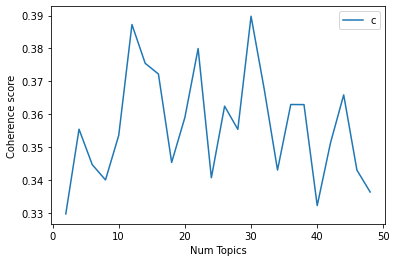

In [25]:
# Show graph for coherence_values
limit=50; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

plt.savefig("Coherence_value.png",dpi=300)
plt.show()

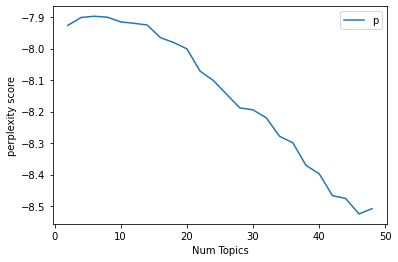

In [26]:
# Show graph for perplexity
limit=50; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, perplexity)
plt.xlabel("Num Topics")
plt.ylabel("perplexity score")
plt.legend(("perplexity"), loc='best')

plt.savefig("Perplexity_value.png",dpi=300)
plt.show()

In [22]:
iterations = 0
for p, cv, i in zip(perplexity, coherence_values, x):
    print("Iteration: ", iterations, ", Number of Topics : ", i, ", Perplexity: ", p, ", CV Score: ", cv, "\n")
    iterations +=1
    

Iteration:  0 , Number of Topics :  2 , Perplexity:  -7.926367306665667 , CV Score:  0.32963037961738006 

Iteration:  1 , Number of Topics :  4 , Perplexity:  -7.901220246623465 , CV Score:  0.3554131956200711 

Iteration:  2 , Number of Topics :  6 , Perplexity:  -7.897246119013744 , CV Score:  0.3446244741180342 

Iteration:  3 , Number of Topics :  8 , Perplexity:  -7.900380761352808 , CV Score:  0.33997650064231505 

Iteration:  4 , Number of Topics :  10 , Perplexity:  -7.91520627955001 , CV Score:  0.3535263314874209 

Iteration:  5 , Number of Topics :  12 , Perplexity:  -7.919606100894244 , CV Score:  0.3872780687362099 

Iteration:  6 , Number of Topics :  14 , Perplexity:  -7.925151649016055 , CV Score:  0.37548456911242084 

Iteration:  7 , Number of Topics :  16 , Perplexity:  -7.965166717797458 , CV Score:  0.37222387330147577 

Iteration:  8 , Number of Topics :  18 , Perplexity:  -7.9807718534892205 , CV Score:  0.34531516876394686 

Iteration:  9 , Number of Topics :  

## Print the topic and words in those topic for Best model i.e topic count = 30

In [76]:
x=model_list[15].show_topics(num_topics=30, num_words=25,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]


#Below Code Prints Topics and Words
for topic,words in topics_words:
    print(str(topic)+ "::"+ str(words),"\n")
    topics.append(topic)
    words.append(words)
print()

# #Below Code Prints Only Words 
# for topic,words in topics_words:
#     print(" ".join(words))

7::['watergate', 'nation', 'united', 'transcript', 'conversation', 'mankind', 'coverup', 'together', 'generation', 'promise', 'investigation', 'future', 'haldeman', 'ehrlichman', 'danger', 'principle', 'committee', 'member', 'personally', 'attack', 'prosecutor', 'conduct', 'country', 'effort', 'anniversary'] 

12::['ireland', 'people', 'american', 'family', 'ballyporeen', 'county', 'united', 'father', 'america', 'general', 'tipperary', 'fought', 'common', 'ranger', 'spirit', 'office', 'difficult', 'welcome', 'europe', 'secretary', 'church', 'cathedral', 'country', 'laughter', 'understand'] 

26::['american', 'nation', 'america', 'president', 'vietnam', 'remember', 'people', 'country', 'family', 'freedom', 'ceremony', 'cannot', 'memorial', 'veteran', 'served', 'luther', 'martin', 'fellow', 'support', 'kennedy', 'church', 'missing', 'learned', 'lesson', 'action'] 

11::['berlin', 'freedom', 'people', 'beyond', 'german', 'germany', 'communist', 'europe', 'offense', 'proudest', 'dividing',

In [77]:
# # Visualize the topics
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

pyLDAvis.enable_notebook(local=False)

D:\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [78]:
lda_visualization = pyLDAvis.gensim.prepare(model_list[15], corpus, id2word, sort_topics=False)
pyLDAvis.display(lda_visualization)

D:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
